In [5]:
# import torch
# import urllib.request

# # Download the pre-trained model weights
# url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt"
# model_path = "model_swinvit.pt"
# urllib.request.urlretrieve(url, model_path)
# print("Model downloaded.")

In [6]:
# !pip install git+https://github.com/cloneofsimo/lora.git

### Preprocessing

In [7]:
#define CUDA version
import os
import shutil
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import torch
torch.cuda.is_available()
torch.version.cuda
!nvcc --version

/bin/bash: /home/rmojtahedi/miniconda3/envs/GPU/lib/libtinfo.so.6: no version information available (required by /bin/bash)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [8]:
# sing_strategy('file_system')#multi-processing 
import matplotlib.pyplot as plt#plot
import numpy as np#import numpy
from tqdm import tqdm#display progression bar
import glob#for finding image files
import os
import natsort 
%matplotlib inline
#-------------------------------------------------------MONAI related libraries
from monai.losses import DiceCELoss#import dice loss
from monai.inferers import sliding_window_inference#import sliding window for inferencing
from monai.utils import first, set_determinism #set the first and determinism(randomness)
from monai.apps import DecathlonDataset#import MSD data set downloader
#data augmentation
from monai.transforms import (
    AsDiscrete,#make thresholding to make discrete part of the object
    Compose,#make transformation
    CropForegroundd,#removes all zero borders to focus on the valid body area of the images and labels.
    RandCropByPosNegLabeld, #randomly crop patch samples from big image based on pos(foreground) / neg(background) ratio
    AddChanneld,#as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
    ToTensord, #making as a tensor to the device
    LoadImaged,#loading the image
    Orientationd,# unifies the data orientation based on the affine matrix
    RandFlipd,#flip the image
    #RandCropByPosNegLabeld, #random crop
    RandShiftIntensityd,#shifting intensity
    ScaleIntensityRanged,#scaling intensity to [0-1]
    Spacingd,#spatial transfomr
    RandRotate90d,#rotate 90 degree
    RandSpatialCropd,#random spatial crop
    RandScaleIntensityd,#random scaling intensity
    EnsureTyped,#ensure type dimension
    EnsureType,
    SpatialCrop,
    RandAffined,
    EnsureChannelFirstd, #ensure that the first dimension and channel is available
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    ResizeWithPadOrCropd,
    NormalizeIntensityd #normalize intensity
)

from monai.networks.layers import Norm#import MONAI normalization
from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDistanceMetric, compute_hausdorff_distance, compute_average_surface_distance #import MONAI metrics
from monai.networks.nets import UNETR#import the network
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch#making decollah batch and dataloader
from monai.losses import DiceLoss



#import MONAI data loader and related loibraries
from monai.data import (
    DataLoader,#loading data
    CacheDataset,#By caching the results of non-random preprocessing transforms, it accelerates the training data pipeline. If the requested data is not in the cache, all transforms will run normally
    load_decathlon_datalist,#oad image/label paths of decathlon challenge from JSON file
    decollate_batch,#simplify the post-processing transforms and enable flexible operations on a batch of model outputs.
)

In [9]:
cacherate=1
sliding_batch_size=num_samples = 1
input_size=(96, 96, 96)
spacing_dim=(1.5, 1.5, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),#loading images
        AddChanneld(keys=["image", "label"]),#adding channel images to device using label and IDs
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=spacing_dim,
            mode=("bilinear", "nearest"),
        ),
        # EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=input_size,
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),#set the tensor to the device
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),#loading images
        AddChanneld(keys=["image", "label"]),#adding channel images to device using label and IDs
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=spacing_dim,
            mode=("bilinear", "nearest"),
        ),
        # EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
        ToTensord(keys=["image", "label"]),#set the tensor to the device
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.


In [10]:
# Training and validation file information as raw strings
train_files_raw = """
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/028-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/028-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/061-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/061-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/091-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/091-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/160-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/160-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/060-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/060-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/144-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/144-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/054-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/054-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/013-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/013-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/022-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/022-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/015-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/015-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/131-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/131-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/112-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/112-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/116-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/116-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/063-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/063-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/146-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/146-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/071-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/071-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/048-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/048-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/033-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/033-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/076-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/076-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/104-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/104-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/030-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/030-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/055-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/055-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/119-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/119-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/155-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/155-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/007-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/007-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/089-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/089-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/056-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/056-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/099-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/099-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/100-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/100-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/004-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/004-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/020-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/020-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/021-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/021-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/052-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/052-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/023-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/023-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/102-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/102-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/134-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/134-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/049-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/049-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/127-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/127-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/077-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/077-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/124-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/124-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/085-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/085-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/105-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/105-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/078-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/078-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/018-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/018-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/123-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/123-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/047-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/047-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/156-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/156-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/150-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/150-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/035-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/035-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/046-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/046-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/074-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/074-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/086-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/086-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/010-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/010-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/098-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/098-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/050-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/050-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/045-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/045-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/006-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/006-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/005-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/005-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/070-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/070-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/017-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/017-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/079-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/079-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/041-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/041-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/003-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/003-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/138-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/138-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/097-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/097-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/024-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/024-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/141-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/141-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/151-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/151-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/125-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/125-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/051-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/051-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/090-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/090-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/137-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/137-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/037-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/037-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/153-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/153-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/129-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/129-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/092-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/092-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/109-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/109-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/107-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/107-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/016-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/016-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/143-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/143-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/117-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/117-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/039-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/039-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/014-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/014-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/065-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/065-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/068-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/068-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/042-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/042-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/158-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/158-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/115-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/115-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/059-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/059-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/072-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/072-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/139-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/139-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/031-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/031-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/029-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/029-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/147-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/147-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/145-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/145-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/009-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/009-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/111-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/111-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/043-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/043-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/096-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/096-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/032-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/032-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/044-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/044-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/066-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/066-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/132-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/132-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/001-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/001-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/133-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/133-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/088-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/088-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/103-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/103-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/108-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/108-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/149-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/149-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/053-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/053-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/159-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/159-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/095-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/095-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/012-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/012-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/002-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/002-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/152-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/152-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/154-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/154-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/008-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/008-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/034-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/034-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/157-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/157-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/113-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/113-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/058-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/058-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/064-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/064-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/073-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/073-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/027-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/027-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/005_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/005_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/087_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/087_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/199_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/199_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/122_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/122_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/078_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/078_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/143_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/143_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/135_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/135_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/200_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/200_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/048_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/048_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/088_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/088_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/193_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/193_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/082_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/082_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/163_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/163_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/008_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/008_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/137_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/137_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/021_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/021_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/012_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/012_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/062_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/062_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/140_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/140_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/024_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/024_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/141_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/141_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/113_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/113_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/198_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/198_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/061_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/061_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/197_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/197_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/036_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/036_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/052_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/052_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/059_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/059_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/152_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/152_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/081_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/081_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/151_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/151_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/106_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/106_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/192_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/192_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/170_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/170_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/035_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/035_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/055_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/055_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/167_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/167_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/132_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/132_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/142_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/142_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/050_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/050_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/164_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/164_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/057_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/057_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/155_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/155_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/191_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/191_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/112_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/112_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/195_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/195_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/042_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/042_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/064_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/064_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/037_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/037_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/053_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/053_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/058_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/058_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/129_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/129_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/124_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/124_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/051_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/051_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/001_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/001_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/022_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/022_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/069_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/069_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/158_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/158_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/114_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/114_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/154_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/154_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/127_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/127_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/031_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/031_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/136_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/136_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/070_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/070_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/126_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/126_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/040_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/040_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/145_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/145_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/189_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/189_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/041_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/041_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/117_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/117_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/075_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/075_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/160_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/160_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/046_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/046_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/086_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/086_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/162_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/162_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/011_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/011_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/115_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/115_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/125_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/125_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/169_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/169_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/194_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/194_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/110_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/110_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/074_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/074_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/060_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/060_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/153_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/153_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/019_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/019_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_128.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_128.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_084.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_084.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_123.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_123.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_316.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_316.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_080.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_080.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_057.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_057.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_062.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_062.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_202.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_202.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_152.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_152.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_050.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_050.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_167.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_167.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_003.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_003.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_079.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_079.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_143.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_143.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_085.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_085.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_101.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_101.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_254.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_254.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_045.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_045.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_219.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_219.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_090.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_090.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_215.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_215.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_176.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_176.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_102.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_102.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_037.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_037.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_107.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_107.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_172.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_172.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_081.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_081.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_250.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_250.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_242.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_242.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_270.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_270.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_278.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_278.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_324.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_324.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_230.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_230.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_203.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_203.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_106.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_106.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_008.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_008.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_147.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_147.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_302.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_302.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_100.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_100.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_096.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_096.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_068.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_068.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_163.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_163.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_112.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_112.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_033.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_033.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_178.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_178.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_039.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_039.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_127.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_127.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_118.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_118.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_212.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_212.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_185.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_185.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_287.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_287.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_044.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_044.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_041.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_041.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_021.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_021.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_292.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_292.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_049.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_049.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_170.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_170.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_149.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_149.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_279.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_279.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_034.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_034.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_281.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_281.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_207.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_207.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_191.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_191.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_272.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_272.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_243.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_243.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_009.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_009.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_321.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_321.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_222.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_222.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_293.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_293.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_285.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_285.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_131.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_131.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_130.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_130.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_179.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_179.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_282.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_282.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_092.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_092.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_157.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_157.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_122.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_122.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_018.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_018.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_217.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_217.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_188.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_188.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_086.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_086.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_155.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_155.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_235.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_235.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_299.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_299.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_014.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_014.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_210.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_210.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_137.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_137.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_300.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_300.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_070.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_070.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_053.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_053.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_307.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_307.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_229.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_229.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_032.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_032.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_237.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_237.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_007.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_007.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_273.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_273.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_226.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_226.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_089.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_089.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_017.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_017.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_169.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_169.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_333.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_333.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_255.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_255.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_271.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_271.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_276.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_276.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_317.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_317.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_109.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_109.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_311.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_311.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_258.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_258.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_198.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_198.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_257.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_257.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_295.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_295.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_301.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_301.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_159.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_159.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_193.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_193.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_012.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_012.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_146.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_146.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_066.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_066.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_260.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_260.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_060.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_060.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_348.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_348.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_247.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_247.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_024.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_024.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_020.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_020.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_002.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_002.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_051.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_051.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_111.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_111.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_294.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_294.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_073.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_073.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_064.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_064.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_150.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_150.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_184.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_184.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_192.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_192.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_306.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_306.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_232.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_232.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_148.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_148.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_284.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_284.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_327.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_327.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_071.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_071.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_233.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_233.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_011.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_011.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_005.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_005.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_268.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_268.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_054.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_054.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_253.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_253.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_132.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_132.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_223.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_223.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_047.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_047.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_097.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_097.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_042.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_042.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_190.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_190.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_103.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_103.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_006.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_006.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_025.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_025.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_165.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_165.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_201.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_201.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_275.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_275.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_065.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_065.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_105.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_105.nii'}
"""

val_files_raw = """
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/122-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/122-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/084-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/084-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/081-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/081-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/083-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/083-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/114-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/114-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/093-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/093-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/140-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/140-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/126-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/126-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/087-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/087-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/019-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/019-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/026-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/026-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/082-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/082-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/038-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/038-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/142-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/142-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/067-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/067-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/025-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/025-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/148-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/148-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/075-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/075-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/036-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/036-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/135-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/135-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/057-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/057-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/094-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/094-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/128-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/128-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/080-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/080-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/106-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/106-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/130-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/130-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/136-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/136-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/069-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/069-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/011-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/011-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/110-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/110-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC/101-hcc_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC/101-hcc_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/049_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/049_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/015_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/015_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/054_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/054_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/023_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/023_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/147_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/147_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/108_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/108_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/134_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/134_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/196_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/196_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/159_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/159_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/014_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/014_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/168_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/168_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/047_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/047_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/120_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/120_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/026_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/026_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/165_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/165_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/043_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/043_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/044_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/044_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/007_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/007_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/144_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/144_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/010_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/010_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/025_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/025_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC/080_ICCrecurrence_volume.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC/080_ICCrecurrence_volume.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_114.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_114.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_069.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_069.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_263.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_263.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_043.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_043.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_296.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_296.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_036.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_036.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_267.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_267.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_320.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_320.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_283.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_283.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_288.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_288.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_077.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_077.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_309.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_309.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_121.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_121.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_326.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_326.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_166.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_166.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_004.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_004.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_046.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_046.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_030.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_030.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_274.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_274.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_234.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_234.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_067.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_067.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_171.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_171.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_013.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_013.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_194.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_194.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_119.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_119.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_126.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_126.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_209.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_209.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_010.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_010.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_001.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_001.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_262.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_262.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_238.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_238.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_205.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_205.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_227.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_227.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_340.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_340.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_056.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_056.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_298.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_298.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_098.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_098.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_019.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_019.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_189.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_189.nii'}
{'image': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC/mcrc_058.nii', 'label': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC/mcrc_058.nii'}
"""

In [11]:
import os
import numpy as np
from monai.transforms import Compose
from monai.data import DataLoader, CacheDataset, Dataset
from collections import OrderedDict

# Function to parse raw file strings into lists of dictionaries
def parse_file_strings(file_strings):
    file_lines = file_strings.strip().split("\n")
    file_dicts = []
    for line in file_lines:
        if line and line.strip():
            # Ensure each line is correctly formatted as a dictionary
            try:
                file_dict = eval(line.strip())
                if isinstance(file_dict, dict) and 'image' in file_dict and 'label' in file_dict:
                    file_dicts.append(file_dict)
                else:
                    print(f"Skipping invalid line: {line.strip()}")
            except Exception as e:
                print(f"Error parsing line: {line.strip()}, Error: {e}")
    return file_dicts

# Parse training and validation file strings
train_files = parse_file_strings(train_files_raw)
val_files = parse_file_strings(val_files_raw)

# Functions to save and load cache
def save_cache(data, filename):
    np.save(filename, data, allow_pickle=True)

def load_cache(filename):
    return np.load(filename, allow_pickle=True)

# Create data loaders with caching
def get_loaders(train_files, val_files, train_transforms, val_transforms, batch_size=1, num_workers=0, cache_dir='./cache'):
    # Create cache directory if it does not exist
    os.makedirs(cache_dir, exist_ok=True)

    # Cache filenames
    train_cache_file = os.path.join(cache_dir, 'train_cache.npy')
    val_cache_file = os.path.join(cache_dir, 'val_cache.npy')

    # Load cache if it exists
    if os.path.exists(train_cache_file) and os.path.exists(val_cache_file):
        print("Loading cached data...")
        train_ds = Dataset(data=load_cache(train_cache_file), transform=train_transforms)
        val_ds = Dataset(data=load_cache(val_cache_file), transform=val_transforms)
    else:
        # Create cached datasets
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
        val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=num_workers)

        # Save cache
        print("Saving cached data...")
        save_cache(train_ds.data, train_cache_file)
        save_cache(val_ds.data, val_cache_file)

    # Create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

    return train_loader, val_loader

# Assuming train_transforms and val_transforms are already defined elsewhere
train_loader, val_loader = get_loaders(train_files, val_files, train_transforms, val_transforms)

# Print confirmation
print("Training and validation data loaders created.")

Loading cached data...
Training and validation data loaders created.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SwinUNETR

class LoRA(nn.Module):
    def __init__(self, original_layer, rank=4):
        super(LoRA, self).__init__()
        self.original_layer = original_layer
        self.rank = rank

        # Create LoRA weights
        self.lora_a = nn.Parameter(torch.randn(original_layer.weight.size(0), rank))
        self.lora_b = nn.Parameter(torch.randn(rank, *original_layer.weight.size()[1:]))

        # Initialize LoRA weights with Xavier initialization
        nn.init.xavier_normal_(self.lora_a)
        nn.init.xavier_normal_(self.lora_b)

    def forward(self, x):
        lora_weight = torch.einsum('ij,jklmn->iklmn', self.lora_a, self.lora_b)
        weight = self.original_layer.weight + lora_weight
        return F.conv3d(x, weight, self.original_layer.bias, stride=self.original_layer.stride, padding=self.original_layer.padding)

def replace_conv_with_lora(module, rank=4):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv3d):
            if child.in_channels != 1:  # Skip the first convolution layer
                lora_conv = LoRA(child, rank).to(device)
                setattr(module, name, lora_conv)
        else:
            replace_conv_with_lora(child, rank)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if CUDA is available
if not torch.cuda.is_available():
    print("CUDA is not available. Please check your CUDA installation.")
else:
    print(f"Using device: {torch.cuda.get_device_name(0)}")

input_size = (96, 96, 96)

def initialize_model():
    model = SwinUNETR(
        in_channels=1,
        out_channels=3,
        img_size=input_size,
        feature_size=48,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=0.0,
        use_checkpoint=True,
    ).to(device)

    # Load pretrained weights before replacing layers
    pretrained_weights = torch.load("./Adaptive.pth")

    # Extract relevant weights and match them to the current model
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    print("Using pretrained self-supervised Swin UNETR backbone weights!")

    # Replace standard convolutions with LoRA convolutions
    replace_conv_with_lora(model, rank=4)

    # Freeze all parameters except for the LoRA parameters
    for name, param in model.named_parameters():
        if 'lora' not in name:
            param.requires_grad = False

    # Unfreeze some additional layers
    for name, param in model.named_parameters():
        if 'encoder' in name or 'decoder' in name:
            param.requires_grad = True

    return model

model = initialize_model()

# Define lora_params
lora_params = [p for p in model.parameters() if p.requires_grad]

# Calculate and print total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Using device: NVIDIA A100-PCIE-40GB
Using pretrained self-supervised Swin UNETR backbone weights!
Total parameters: 62703825
Trainable parameters: 54641676


In [15]:
import time
import torch
import numpy as np
from tqdm import tqdm
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import os

# Define the root directory as the current directory
root_dir = os.getcwd()
save_root_dir = os.path.join(root_dir, "LORA")
os.makedirs(save_root_dir, exist_ok=True)

torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False)
hd95_metric = HausdorffDistanceMetric(include_background=False, percentile=95, reduction="mean_batch", get_not_nans=False)

# Early stopping parameters
patience = 5
best_tumor_dice = 0.0
counter = 0

iteration_times = []

def validation(epoch_iterator_val, epoch):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            hd95_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        
        dice_scores = dice_metric.aggregate().cpu().numpy()
        hd95_scores = hd95_metric.aggregate().cpu().numpy()
        liver_dice = dice_scores[0]
        tumor_dice = dice_scores[1]
        liver_hd95 = hd95_scores[0]
        tumor_hd95 = hd95_scores[1]
        dice_metric.reset()
        hd95_metric.reset()

    print(f"Epoch {epoch}: Liver Dice: {liver_dice}, Tumor Dice: {tumor_dice}, Liver HD95: {liver_hd95}, Tumor HD95: {tumor_hd95}")
    return liver_dice, tumor_dice, liver_hd95, tumor_hd95

def train(global_step, train_loader, dice_val_best, global_step_best, save_dir):
    global best_tumor_dice, counter, iteration_times
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        start_time = time.time()
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        end_time = time.time()
        iteration_time = (end_time - start_time) * 1000  # Convert to milliseconds
        iteration_times.append(iteration_time)
        epoch_iterator.set_description(
            f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})"
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            liver_dice, tumor_dice, liver_hd95, tumor_hd95 = validation(epoch_iterator_val, global_step // eval_num)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append((liver_dice, tumor_dice, liver_hd95, tumor_hd95))
            np.save(os.path.join(save_dir, "metric_values.npy"), np.array(metric_values))
            np.save(os.path.join(save_dir, "epoch_loss_values.npy"), np.array(epoch_loss_values))
            np.save(os.path.join(save_dir, "iteration_times.npy"), np.array(iteration_times))
            if tumor_dice > best_tumor_dice:
                best_tumor_dice = tumor_dice
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(save_dir, "LORA.pth"))
                print(
                    "Model Was Saved ! Current Best Tumor Dice: {} Current Tumor Dice: {}".format(best_tumor_dice, tumor_dice)
                )
                counter = 0  # Reset the counter if we get a new best dice score
            else:
                print(
                    "Model Was Not Saved ! Current Best Tumor Dice: {} Current Tumor Dice: {}".format(
                        best_tumor_dice, tumor_dice
                    )
                )
                counter += 1  # Increment the counter if no improvement
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {global_step // eval_num}")
                    return global_step, dice_val_best, global_step_best, True
        
        global_step += 1
    return global_step, dice_val_best, global_step_best, False

max_iterations = 5000
eval_num = 500
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
epoch_times = []

early_stop = False

# Define the split ratios and names
splits = [(0.3, '30%'), (0.7, '70%'), (1.0, '100%')]

# Assume train_loader and val_loader are already defined in another cell
for split_ratio, split_name in splits:
    print(f"Processing split ratio: {split_name}")
    
    # Create split directory
    split_save_dir = os.path.join(save_root_dir, split_name)
    os.makedirs(split_save_dir, exist_ok=True)
    
    # Split the dataset
    train_files_split = train_files[:int(len(train_files) * split_ratio)]
    
    # Create data loaders with the split dataset
    train_ds_split = Dataset(data=train_files_split, transform=train_transforms)
    train_loader_split = DataLoader(train_ds_split, batch_size=train_loader.batch_size, num_workers=train_loader.num_workers)
    
    # Reinitialize the model and load the initial pretrained weights
    model = initialize_model()
    
    # Define lora_params after model reinitialization
    lora_params = [p for p in model.parameters() if p.requires_grad]

    # Reinitialize the optimizer with new lora_params
    optimizer = torch.optim.AdamW(lora_params, lr=1e-4, weight_decay=1e-5)

    # Reset training parameters for each split
    global_step = 0
    dice_val_best = 0.0
    global_step_best = 0
    epoch_loss_values = []
    metric_values = []
    iteration_times = []
    best_tumor_dice = 0.0
    counter = 0
    early_stop = False
    
    while global_step < max_iterations and not early_stop:
        try:
            global_step, dice_val_best, global_step_best, early_stop = train(global_step, train_loader_split, dice_val_best, global_step_best, split_save_dir)
        except KeyboardInterrupt:
            print("Training interrupted. Saving current state.")
            torch.save(model.state_dict(), os.path.join(split_save_dir, "LORA.pth"))
            break

    if not early_stop:
        model.load_state_dict(torch.load(os.path.join(split_save_dir, "LORA.pth")))

    # Save metrics to plot later
    np.save(os.path.join(split_save_dir, "metric_values.npy"), np.array(metric_values))
    np.save(os.path.join(split_save_dir, "epoch_loss_values.npy"), np.array(epoch_loss_values))
    np.save(os.path.join(split_save_dir, "iteration_times.npy"), np.array(iteration_times))

    # Calculate and print average training time per epoch based on iteration times
    if iteration_times:
        avg_iteration_time = np.mean(iteration_times)
        avg_epoch_time = avg_iteration_time * len(train_loader_split)  # Approximate number of iterations per epoch
        print(f"Average training time per epoch for {split_name}: {avg_epoch_time:.2f} ms")
    else:
        print(f"No iterations were recorded for {split_name}.")

Processing split ratio: 30%
Using pretrained self-supervised Swin UNETR backbone weights!


Validate (440 / 10 Steps): 100%|██████████| 93/93 [10:43<00:00,  6.92s/it]<00:59,  1.20s/it]


Epoch 1: Liver Dice: 0.895289421081543, Tumor Dice: 0.35853490233421326, Liver HD95: 62.28670120239258, Tumor HD95: 131.77259826660156


Training (500 / 5000 Steps) (loss=0.50986):  55%|█████▌    | 61/110 [12:19<2:38:44, 194.38s/it]

Model Was Saved ! Current Best Tumor Dice: 0.35853490233421326 Current Tumor Dice: 0.35853490233421326


Training (1000 / 5000 Steps) (loss=0.62450):   9%|▉         | 10/110 [00:18<02:18,  1.39s/it]the prediction of class 1 is all 0, this may result in nan/inf distance.
invalid value encountered in subtract
Training (1000 / 5000 Steps) (loss=0.62450):  10%|█         | 11/110 [08:29<4:10:34, 151.86s/it]

Epoch 2: Liver Dice: 0.9125823974609375, Tumor Dice: 0.3341033160686493, Liver HD95: 19.12495994567871, Tumor HD95: 68.97322845458984
Model Was Not Saved ! Current Best Tumor Dice: 0.35853490233421326 Current Tumor Dice: 0.3341033160686493


Validate (1430 / 10 Steps): 100%|██████████| 93/93 [08:09<00:00,  5.27s/it]<01:02,  1.56s/it]


Epoch 3: Liver Dice: 0.9139540195465088, Tumor Dice: 0.4193784296512604, Liver HD95: 18.679685592651367, Tumor HD95: 81.7497329711914


Training (1500 / 5000 Steps) (loss=0.43987):  65%|██████▍   | 71/110 [10:01<1:36:41, 148.76s/it]

Model Was Saved ! Current Best Tumor Dice: 0.4193784296512604 Current Tumor Dice: 0.4193784296512604


Validate (1980 / 10 Steps): 100%|██████████| 93/93 [07:10<00:00,  4.63s/it]<02:41,  1.79s/it]


Epoch 4: Liver Dice: 0.9178048372268677, Tumor Dice: 0.4265701174736023, Liver HD95: 13.542071342468262, Tumor HD95: 50.327762603759766


Training (2000 / 5000 Steps) (loss=0.16828):  19%|█▉        | 21/110 [07:49<3:14:29, 131.12s/it]

Model Was Saved ! Current Best Tumor Dice: 0.4265701174736023 Current Tumor Dice: 0.4265701174736023


Training (2500 / 5000 Steps) (loss=0.59551):  74%|███████▎  | 81/110 [09:16<1:02:37, 129.56s/it]

Epoch 5: Liver Dice: 0.919701337814331, Tumor Dice: 0.40765008330345154, Liver HD95: 13.060577392578125, Tumor HD95: 43.48970413208008
Model Was Not Saved ! Current Best Tumor Dice: 0.4265701174736023 Current Tumor Dice: 0.40765008330345154


Training (3000 / 5000 Steps) (loss=0.37889):  28%|██▊       | 31/110 [08:30<3:02:47, 138.83s/it]

Epoch 6: Liver Dice: 0.9191657304763794, Tumor Dice: 0.415383905172348, Liver HD95: 24.293777465820312, Tumor HD95: 74.42998504638672
Model Was Not Saved ! Current Best Tumor Dice: 0.4265701174736023 Current Tumor Dice: 0.415383905172348


Validate (3410 / 10 Steps): 100%|██████████| 93/93 [07:18<00:00,  4.72s/it]<00:25,  1.30s/it]


Epoch 7: Liver Dice: 0.9183664917945862, Tumor Dice: 0.44337552785873413, Liver HD95: 12.11472225189209, Tumor HD95: 60.180763244628906


Training (3500 / 5000 Steps) (loss=0.67073):  83%|████████▎ | 91/110 [09:45<42:08, 133.08s/it]

Model Was Saved ! Current Best Tumor Dice: 0.44337552785873413 Current Tumor Dice: 0.44337552785873413


Validate (3960 / 10 Steps): 100%|██████████| 93/93 [07:26<00:00,  4.80s/it]<01:50,  1.57s/it]


Epoch 8: Liver Dice: 0.9177654385566711, Tumor Dice: 0.4556814134120941, Liver HD95: 29.735530853271484, Tumor HD95: 55.953250885009766


Training (4000 / 5000 Steps) (loss=0.36954):  37%|███▋      | 41/110 [08:35<2:35:59, 135.65s/it]

Model Was Saved ! Current Best Tumor Dice: 0.4556814134120941 Current Tumor Dice: 0.4556814134120941


Training (4500 / 5000 Steps) (loss=0.35779):  92%|█████████▏| 101/110 [10:18<20:55, 139.52s/it]

Epoch 9: Liver Dice: 0.9181163907051086, Tumor Dice: 0.4430708587169647, Liver HD95: 13.48090934753418, Tumor HD95: 88.46246337890625
Model Was Not Saved ! Current Best Tumor Dice: 0.4556814134120941 Current Tumor Dice: 0.4430708587169647


Validate (4950 / 10 Steps): 100%|██████████| 93/93 [07:21<00:00,  4.75s/it]<01:24,  1.41s/it]


Epoch 10: Liver Dice: 0.9192954301834106, Tumor Dice: 0.4581649899482727, Liver HD95: 18.067569732666016, Tumor HD95: 63.621158599853516


Training (5000 / 5000 Steps) (loss=0.84643):  46%|████▋     | 51/110 [08:44<2:11:54, 134.14s/it]

Model Was Saved ! Current Best Tumor Dice: 0.4581649899482727 Current Tumor Dice: 0.4581649899482727


Training (5059 / 5000 Steps) (loss=0.44765): 100%|██████████| 110/110 [10:14<00:00,  5.59s/it]  


Average training time per epoch for 30%: 13127.11 ms
Processing split ratio: 70%
Using pretrained self-supervised Swin UNETR backbone weights!


Validate (256 / 10 Steps): 100%|██████████| 93/93 [07:41<00:00,  4.96s/it]8<00:33,  2.76s/it]


Epoch 1: Liver Dice: 0.9047415256500244, Tumor Dice: 0.2978123426437378, Liver HD95: 17.180952072143555, Tumor HD95: 37.73583984375


Training (500 / 5000 Steps) (loss=0.49626):  96%|█████████▌| 245/256 [15:00<25:51, 141.08s/it]

Model Was Saved ! Current Best Tumor Dice: 0.2978123426437378 Current Tumor Dice: 0.2978123426437378


Training (1000 / 5000 Steps) (loss=0.45621):  91%|█████████ | 233/256 [14:30<53:47, 140.33s/it]

Epoch 2: Liver Dice: 0.911719024181366, Tumor Dice: 0.28476330637931824, Liver HD95: 16.60480499267578, Tumor HD95: 33.292930603027344
Model Was Not Saved ! Current Best Tumor Dice: 0.2978123426437378 Current Tumor Dice: 0.28476330637931824


Validate (1280 / 10 Steps): 100%|██████████| 93/93 [08:37<00:00,  5.57s/it]5<01:56,  3.25s/it]


Epoch 3: Liver Dice: 0.9035611748695374, Tumor Dice: 0.39072203636169434, Liver HD95: 35.632137298583984, Tumor HD95: 86.31210327148438


Training (1500 / 5000 Steps) (loss=0.69869):  86%|████████▋ | 221/256 [15:13<1:32:22, 158.35s/it]

Model Was Saved ! Current Best Tumor Dice: 0.39072203636169434 Current Tumor Dice: 0.39072203636169434


Validate (1792 / 10 Steps): 100%|██████████| 93/93 [09:31<00:00,  6.15s/it]2<01:22,  1.71s/it]


Epoch 4: Liver Dice: 0.8434185981750488, Tumor Dice: 0.40006223320961, Liver HD95: 99.42903900146484, Tumor HD95: 67.2270278930664


Training (2000 / 5000 Steps) (loss=0.96682):  82%|████████▏ | 209/256 [15:14<2:15:55, 173.52s/it]

Model Was Saved ! Current Best Tumor Dice: 0.40006223320961 Current Tumor Dice: 0.40006223320961


Validate (2304 / 10 Steps): 100%|██████████| 93/93 [08:14<00:00,  5.32s/it]0<01:21,  1.36s/it]


Epoch 5: Liver Dice: 0.9124951362609863, Tumor Dice: 0.419964462518692, Liver HD95: 34.55937957763672, Tumor HD95: 49.585960388183594


Training (2500 / 5000 Steps) (loss=0.45461):  77%|███████▋  | 197/256 [13:35<2:27:32, 150.04s/it]

Model Was Saved ! Current Best Tumor Dice: 0.419964462518692 Current Tumor Dice: 0.419964462518692


Training (3000 / 5000 Steps) (loss=0.69299):  72%|███████▏  | 185/256 [14:58<3:32:30, 179.58s/it]

Epoch 6: Liver Dice: 0.8923019766807556, Tumor Dice: 0.38545411825180054, Liver HD95: 90.80056762695312, Tumor HD95: 130.7832489013672
Model Was Not Saved ! Current Best Tumor Dice: 0.419964462518692 Current Tumor Dice: 0.38545411825180054


Validate (3328 / 10 Steps): 100%|██████████| 93/93 [07:32<00:00,  4.87s/it]9<02:07,  1.52s/it]


Epoch 7: Liver Dice: 0.9207896590232849, Tumor Dice: 0.4821436405181885, Liver HD95: 11.799304962158203, Tumor HD95: 53.87612533569336


Training (3500 / 5000 Steps) (loss=0.68007):  68%|██████▊   | 173/256 [12:12<3:10:42, 137.86s/it]

Model Was Saved ! Current Best Tumor Dice: 0.4821436405181885 Current Tumor Dice: 0.4821436405181885


Training (4000 / 5000 Steps) (loss=0.53282):  63%|██████▎   | 161/256 [12:20<3:51:27, 146.19s/it]

Epoch 8: Liver Dice: 0.9028241634368896, Tumor Dice: 0.4619308412075043, Liver HD95: 29.71407699584961, Tumor HD95: 51.75209045410156
Model Was Not Saved ! Current Best Tumor Dice: 0.4821436405181885 Current Tumor Dice: 0.4619308412075043


Training (4500 / 5000 Steps) (loss=0.24988):  58%|█████▊    | 149/256 [11:55<4:22:18, 147.09s/it]

Epoch 9: Liver Dice: 0.8935328722000122, Tumor Dice: 0.44310542941093445, Liver HD95: 40.09141540527344, Tumor HD95: 68.69493865966797
Model Was Not Saved ! Current Best Tumor Dice: 0.4821436405181885 Current Tumor Dice: 0.44310542941093445


Training (5000 / 5000 Steps) (loss=3.86202):  54%|█████▎    | 137/256 [11:26<4:40:09, 141.26s/it]

Epoch 10: Liver Dice: 0.9204389452934265, Tumor Dice: 0.3980640769004822, Liver HD95: 11.881403923034668, Tumor HD95: 30.59077262878418
Model Was Not Saved ! Current Best Tumor Dice: 0.4821436405181885 Current Tumor Dice: 0.3980640769004822


Training (5119 / 5000 Steps) (loss=0.22473): 100%|██████████| 256/256 [15:34<00:00,  3.65s/it]   


Average training time per epoch for 70%: 30859.48 ms
Processing split ratio: 100%
Using pretrained self-supervised Swin UNETR backbone weights!


Validate (367 / 10 Steps): 100%|██████████| 93/93 [08:32<00:00,  5.51s/it]7<07:13,  1.85s/it]


Epoch 1: Liver Dice: 0.9001199007034302, Tumor Dice: 0.23406770825386047, Liver HD95: 36.56288528442383, Tumor HD95: 63.97126770019531


Training (500 / 5000 Steps) (loss=0.27829):  37%|███▋      | 134/367 [12:09<10:04:57, 155.78s/it]

Model Was Saved ! Current Best Tumor Dice: 0.23406770825386047 Current Tumor Dice: 0.23406770825386047


Validate (734 / 10 Steps): 100%|██████████| 93/93 [07:52<00:00,  5.08s/it]22<06:35,  3.91s/it]


Epoch 2: Liver Dice: 0.9154024720191956, Tumor Dice: 0.3921145796775818, Liver HD95: 20.399471282958984, Tumor HD95: 53.49344253540039


Training (1000 / 5000 Steps) (loss=0.68127):  73%|███████▎  | 267/367 [16:15<4:01:33, 144.93s/it]

Model Was Saved ! Current Best Tumor Dice: 0.3921145796775818 Current Tumor Dice: 0.3921145796775818


Validate (1468 / 10 Steps): 100%|██████████| 93/93 [08:25<00:00,  5.44s/it]<07:11,  1.29s/it]


Epoch 3: Liver Dice: 0.9091829061508179, Tumor Dice: 0.4146726131439209, Liver HD95: 46.490291595458984, Tumor HD95: 75.69783782958984


Training (1500 / 5000 Steps) (loss=0.55072):   9%|▉         | 33/367 [09:21<14:12:04, 153.07s/it]

Model Was Saved ! Current Best Tumor Dice: 0.4146726131439209 Current Tumor Dice: 0.4146726131439209


Training (2000 / 5000 Steps) (loss=0.41647):  45%|████▌     | 166/367 [13:37<9:19:18, 166.96s/it]

Epoch 4: Liver Dice: 0.8818933367729187, Tumor Dice: 0.3745628297328949, Liver HD95: 57.552772521972656, Tumor HD95: 120.21357727050781
Model Was Not Saved ! Current Best Tumor Dice: 0.4146726131439209 Current Tumor Dice: 0.3745628297328949


Training (2500 / 5000 Steps) (loss=0.46085):  81%|████████▏ | 299/367 [17:41<2:28:35, 131.12s/it]

Epoch 5: Liver Dice: 0.9147965908050537, Tumor Dice: 0.3786955773830414, Liver HD95: 17.8124942779541, Tumor HD95: 42.37503433227539
Model Was Not Saved ! Current Best Tumor Dice: 0.4146726131439209 Current Tumor Dice: 0.3786955773830414


Validate (2936 / 10 Steps): 100%|██████████| 93/93 [07:35<00:00,  4.90s/it]<06:51,  1.36s/it]


Epoch 6: Liver Dice: 0.920305073261261, Tumor Dice: 0.44236233830451965, Liver HD95: 16.448997497558594, Tumor HD95: 71.18944549560547


Training (3000 / 5000 Steps) (loss=0.63367):  18%|█▊        | 65/367 [09:16<11:34:47, 138.04s/it]

Model Was Saved ! Current Best Tumor Dice: 0.44236233830451965 Current Tumor Dice: 0.44236233830451965


Validate (3303 / 10 Steps): 100%|██████████| 93/93 [08:57<00:00,  5.78s/it]4<04:23,  1.55s/it]


Epoch 7: Liver Dice: 0.9213618040084839, Tumor Dice: 0.481190025806427, Liver HD95: 59.44316864013672, Tumor HD95: 61.52615737915039


Training (3500 / 5000 Steps) (loss=0.44804):  54%|█████▍    | 198/367 [14:22<7:39:19, 163.07s/it]

Model Was Saved ! Current Best Tumor Dice: 0.481190025806427 Current Tumor Dice: 0.481190025806427


Training (4000 / 5000 Steps) (loss=0.29552):  90%|█████████ | 331/367 [19:39<1:19:08, 131.91s/it]

Epoch 8: Liver Dice: 0.9203932285308838, Tumor Dice: 0.4447679817676544, Liver HD95: 11.163393020629883, Tumor HD95: 46.47349166870117
Model Was Not Saved ! Current Best Tumor Dice: 0.481190025806427 Current Tumor Dice: 0.4447679817676544


Training (4500 / 5000 Steps) (loss=0.77331):  26%|██▋       | 97/367 [10:46<11:16:21, 150.30s/it]

Epoch 9: Liver Dice: 0.9236751794815063, Tumor Dice: 0.40915802121162415, Liver HD95: 17.38623046875, Tumor HD95: 139.63414001464844
Model Was Not Saved ! Current Best Tumor Dice: 0.481190025806427 Current Tumor Dice: 0.40915802121162415


Training (5000 / 5000 Steps) (loss=0.47390):  63%|██████▎   | 230/367 [14:17<5:16:40, 138.69s/it]

Epoch 10: Liver Dice: 0.9234483242034912, Tumor Dice: 0.47421419620513916, Liver HD95: 12.547894477844238, Tumor HD95: 60.498409271240234
Model Was Not Saved ! Current Best Tumor Dice: 0.481190025806427 Current Tumor Dice: 0.47421419620513916


Training (5137 / 5000 Steps) (loss=0.40527): 100%|██████████| 367/367 [20:58<00:00,  3.43s/it]   

Average training time per epoch for 100%: 44966.90 ms


In [1]:
pwd

'/mnt/largedrive0/rmojtahedi/MICCAI2024/LORA'

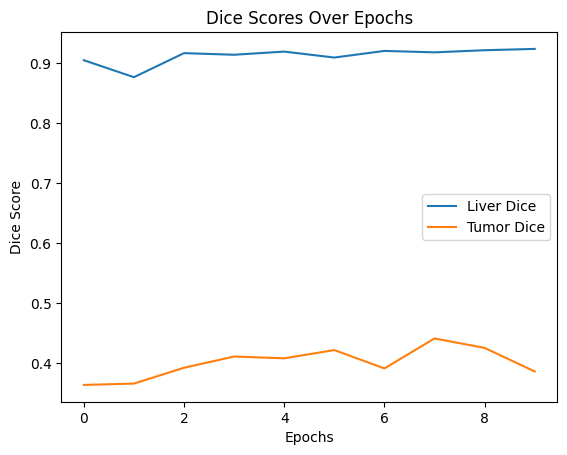

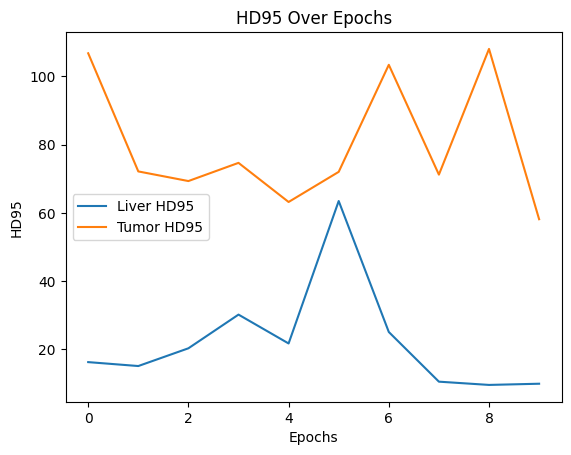

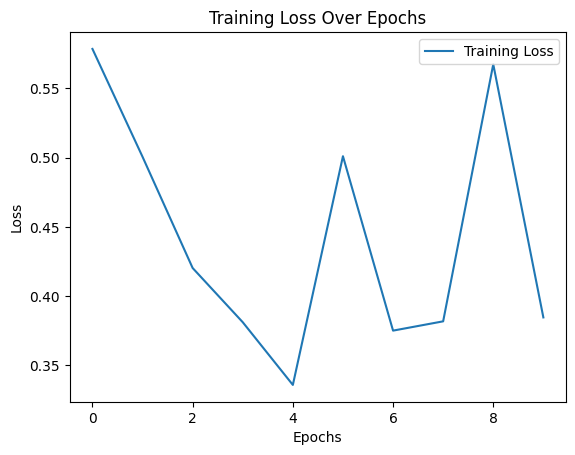

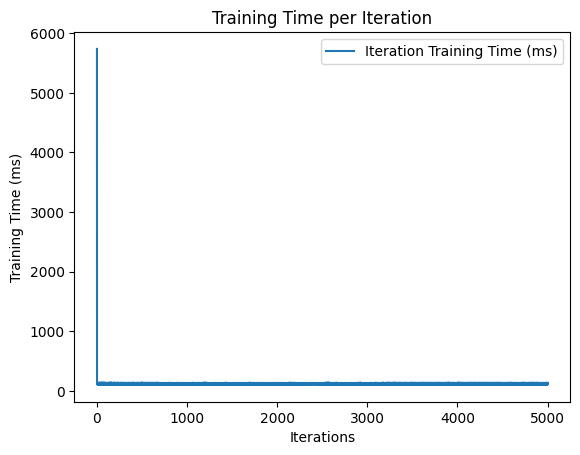

Best Liver Dice: 0.9232404232025146
Best Tumor Dice: 0.440783828496933
Best Liver HD95: 9.540149688720703
Best Tumor HD95: 58.13031005859375
Average training time per epoch: 60241.72 ms


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved metrics
save_dir = "10%"
metric_values = np.load(os.path.join(save_dir, 'metric_values.npy'))
epoch_loss_values = np.load(os.path.join(save_dir, 'epoch_loss_values.npy'))
iteration_times = np.load(os.path.join(save_dir, 'iteration_times.npy'))

# Split the metric values
liver_dice = metric_values[:, 0]
tumor_dice = metric_values[:, 1]
liver_hd95 = metric_values[:, 2]
tumor_hd95 = metric_values[:, 3]

# Plot Dice scores
plt.figure()
plt.plot(liver_dice, label='Liver Dice')
plt.plot(tumor_dice, label='Tumor Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Dice Scores Over Epochs')
plt.legend()
plt.show()

# Plot HD95 scores
plt.figure()
plt.plot(liver_hd95, label='Liver HD95')
plt.plot(tumor_hd95, label='Tumor HD95')
plt.xlabel('Epochs')
plt.ylabel('HD95')
plt.title('HD95 Over Epochs')
plt.legend()
plt.show()

# Plot epoch loss
plt.figure()
plt.plot(epoch_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot iteration times
plt.figure()
plt.plot(iteration_times, label='Iteration Training Time (ms)')
plt.xlabel('Iterations')
plt.ylabel('Training Time (ms)')
plt.title('Training Time per Iteration')
plt.legend()
plt.show()

# Print the best results
best_liver_dice = np.max(liver_dice)
best_tumor_dice = np.max(tumor_dice)
best_liver_hd95 = np.min(liver_hd95)
best_tumor_hd95 = np.min(tumor_hd95)

print(f"Best Liver Dice: {best_liver_dice}")
print(f"Best Tumor Dice: {best_tumor_dice}")
print(f"Best Liver HD95: {best_liver_hd95}")
print(f"Best Tumor HD95: {best_tumor_hd95}")

# Print the average training time per epoch based on iteration times
if iteration_times.size > 0:
    avg_iteration_time = np.mean(iteration_times)
    train_loader_len = len(iteration_times) // len(liver_dice)  # Approximate number of iterations per epoch
    avg_epoch_time = avg_iteration_time * train_loader_len
    print(f"Average training time per epoch: {avg_epoch_time:.2f} ms")
else:
    print("No iterations were recorded.")

In [25]:
import os
import torch
import numpy as np
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from scipy.ndimage import label

# Define the root directory and load the model
root_dir = os.getcwd()
save_dir = os.path.join(root_dir, "10%")
model_path = os.path.join(save_dir, "LORA.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

# Define the post-processing and metrics
post_label = AsDiscrete(to_onehot=3)  # Assuming the labels are background, liver, and tumor
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False)
hd95_metric = HausdorffDistanceMetric(include_background=False, percentile=95, reduction="mean_batch", get_not_nans=False)

# Function to find the largest connected component
def get_largest_connected_component(segmentation):
    labeled_array, num_features = label(segmentation)
    if num_features < 1:
        return segmentation
    largest_cc = (labeled_array == np.argmax(np.bincount(labeled_array.flat)[1:]) + 1).astype(int)
    return largest_cc

# Validation function to calculate metrics for the largest tumor
def validation_for_largest_tumor(val_loader):
    largest_tumor_dice_scores = []
    largest_tumor_hd95_scores = []
    with torch.no_grad():
        for batch in val_loader:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            
            for val_pred, val_label in zip(val_output_convert, val_labels_convert):
                pred_tumor = val_pred[2].cpu().numpy()  # Assuming class 2 is the tumor
                largest_tumor = get_largest_connected_component(pred_tumor)
                largest_tumor = torch.tensor(largest_tumor).unsqueeze(0).cuda()
                
                if torch.sum(val_label[2]) > 0 and torch.sum(largest_tumor) > 0:
                    dice_metric(y_pred=largest_tumor, y=val_label[2].unsqueeze(0))
                    hd95_metric(y_pred=largest_tumor, y=val_label[2].unsqueeze(0))
                    
                    largest_tumor_dice_scores.append(dice_metric.aggregate().cpu().numpy()[0])
                    largest_tumor_hd95_scores.append(hd95_metric.aggregate().cpu().numpy()[0])
                    
                    dice_metric.reset()
                    hd95_metric.reset()
    
    if len(largest_tumor_dice_scores) > 0 and len(largest_tumor_hd95_scores) > 0:
        return np.mean(largest_tumor_dice_scores), np.mean(largest_tumor_hd95_scores)
    else:
        return float('nan'), float('nan')

# Assuming val_loader is defined
largest_tumor_dice, largest_tumor_hd95 = validation_for_largest_tumor(val_loader)
print(f"Largest Tumor Dice: {largest_tumor_dice}, Largest Tumor HD95: {largest_tumor_hd95}")

the ground truth of class 313 is all 0, this may result in nan/inf distance.
the prediction of class 313 is all 0, this may result in nan/inf distance.
the ground truth of class 314 is all 0, this may result in nan/inf distance.
the prediction of class 314 is all 0, this may result in nan/inf distance.


Largest Tumor Dice: 0.0, Largest Tumor HD95: 0.0


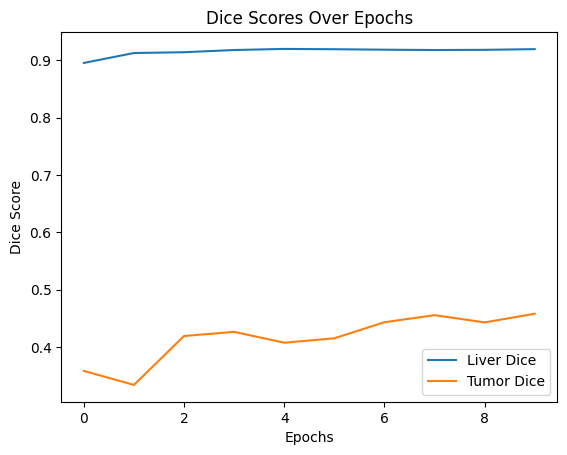

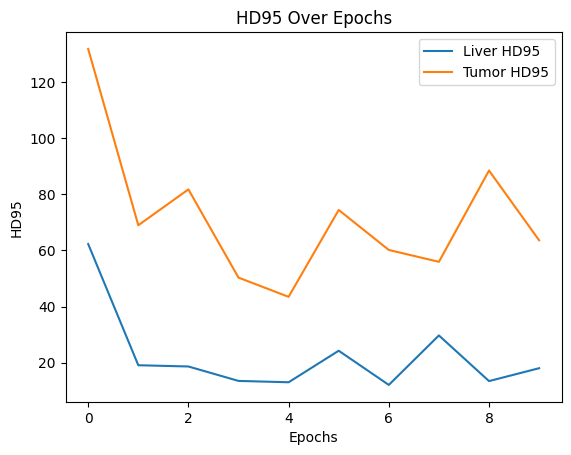

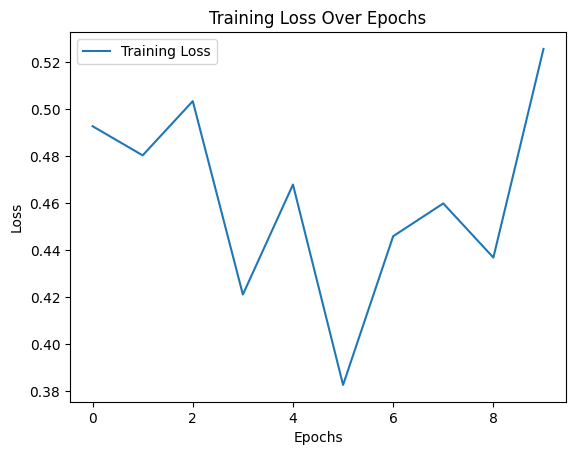

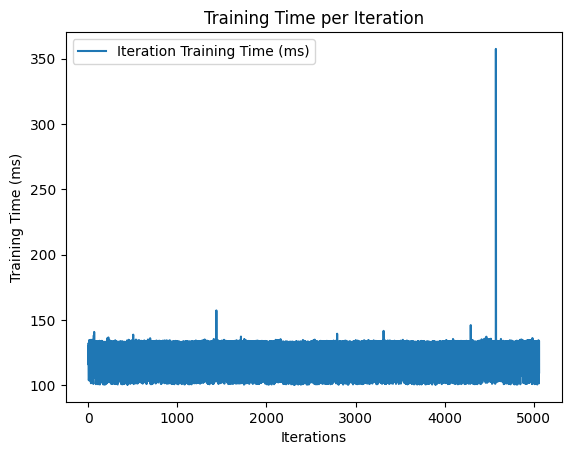

Best Liver Dice: 0.919701337814331
Best Tumor Dice: 0.4581649899482727
Best Liver HD95: 12.11472225189209
Best Tumor HD95: 43.48970413208008
Average training time per epoch: 60384.69 ms


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved metrics
save_dir = "30%"
metric_values = np.load(os.path.join(save_dir, 'metric_values.npy'))
epoch_loss_values = np.load(os.path.join(save_dir, 'epoch_loss_values.npy'))
iteration_times = np.load(os.path.join(save_dir, 'iteration_times.npy'))

# Split the metric values
liver_dice = metric_values[:, 0]
tumor_dice = metric_values[:, 1]
liver_hd95 = metric_values[:, 2]
tumor_hd95 = metric_values[:, 3]

# Plot Dice scores
plt.figure()
plt.plot(liver_dice, label='Liver Dice')
plt.plot(tumor_dice, label='Tumor Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Dice Scores Over Epochs')
plt.legend()
plt.show()

# Plot HD95 scores
plt.figure()
plt.plot(liver_hd95, label='Liver HD95')
plt.plot(tumor_hd95, label='Tumor HD95')
plt.xlabel('Epochs')
plt.ylabel('HD95')
plt.title('HD95 Over Epochs')
plt.legend()
plt.show()

# Plot epoch loss
plt.figure()
plt.plot(epoch_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot iteration times
plt.figure()
plt.plot(iteration_times, label='Iteration Training Time (ms)')
plt.xlabel('Iterations')
plt.ylabel('Training Time (ms)')
plt.title('Training Time per Iteration')
plt.legend()
plt.show()

# Print the best results
best_liver_dice = np.max(liver_dice)
best_tumor_dice = np.max(tumor_dice)
best_liver_hd95 = np.min(liver_hd95)
best_tumor_hd95 = np.min(tumor_hd95)

print(f"Best Liver Dice: {best_liver_dice}")
print(f"Best Tumor Dice: {best_tumor_dice}")
print(f"Best Liver HD95: {best_liver_hd95}")
print(f"Best Tumor HD95: {best_tumor_hd95}")

# Print the average training time per epoch based on iteration times
if iteration_times.size > 0:
    avg_iteration_time = np.mean(iteration_times)
    train_loader_len = len(iteration_times) // len(liver_dice)  # Approximate number of iterations per epoch
    avg_epoch_time = avg_iteration_time * train_loader_len
    print(f"Average training time per epoch: {avg_epoch_time:.2f} ms")
else:
    print("No iterations were recorded.")

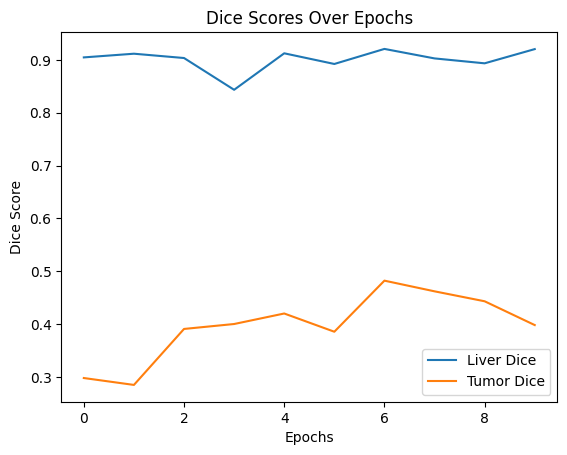

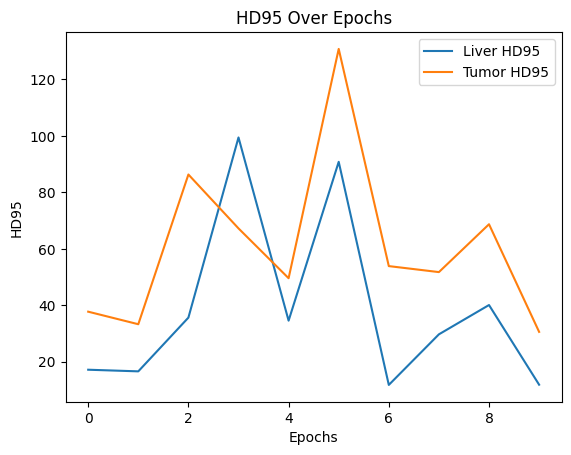

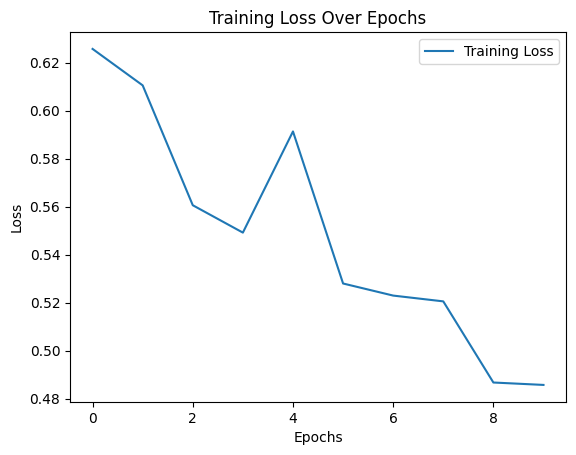

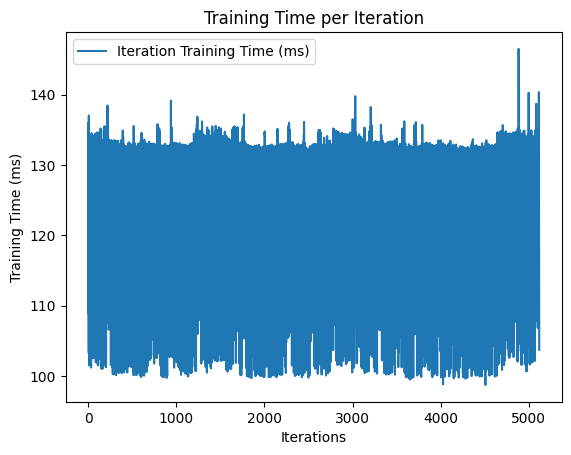

Best Liver Dice: 0.9207896590232849
Best Tumor Dice: 0.4821436405181885
Best Liver HD95: 11.799304962158203
Best Tumor HD95: 30.59077262878418
Average training time per epoch: 61718.96 ms


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved metrics
save_dir = "70%"
metric_values = np.load(os.path.join(save_dir, 'metric_values.npy'))
epoch_loss_values = np.load(os.path.join(save_dir, 'epoch_loss_values.npy'))
iteration_times = np.load(os.path.join(save_dir, 'iteration_times.npy'))

# Split the metric values
liver_dice = metric_values[:, 0]
tumor_dice = metric_values[:, 1]
liver_hd95 = metric_values[:, 2]
tumor_hd95 = metric_values[:, 3]

# Plot Dice scores
plt.figure()
plt.plot(liver_dice, label='Liver Dice')
plt.plot(tumor_dice, label='Tumor Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Dice Scores Over Epochs')
plt.legend()
plt.show()

# Plot HD95 scores
plt.figure()
plt.plot(liver_hd95, label='Liver HD95')
plt.plot(tumor_hd95, label='Tumor HD95')
plt.xlabel('Epochs')
plt.ylabel('HD95')
plt.title('HD95 Over Epochs')
plt.legend()
plt.show()

# Plot epoch loss
plt.figure()
plt.plot(epoch_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot iteration times
plt.figure()
plt.plot(iteration_times, label='Iteration Training Time (ms)')
plt.xlabel('Iterations')
plt.ylabel('Training Time (ms)')
plt.title('Training Time per Iteration')
plt.legend()
plt.show()

# Print the best results
best_liver_dice = np.max(liver_dice)
best_tumor_dice = np.max(tumor_dice)
best_liver_hd95 = np.min(liver_hd95)
best_tumor_hd95 = np.min(tumor_hd95)

print(f"Best Liver Dice: {best_liver_dice}")
print(f"Best Tumor Dice: {best_tumor_dice}")
print(f"Best Liver HD95: {best_liver_hd95}")
print(f"Best Tumor HD95: {best_tumor_hd95}")

# Print the average training time per epoch based on iteration times
if iteration_times.size > 0:
    avg_iteration_time = np.mean(iteration_times)
    train_loader_len = len(iteration_times) // len(liver_dice)  # Approximate number of iterations per epoch
    avg_epoch_time = avg_iteration_time * train_loader_len
    print(f"Average training time per epoch: {avg_epoch_time:.2f} ms")
else:
    print("No iterations were recorded.")

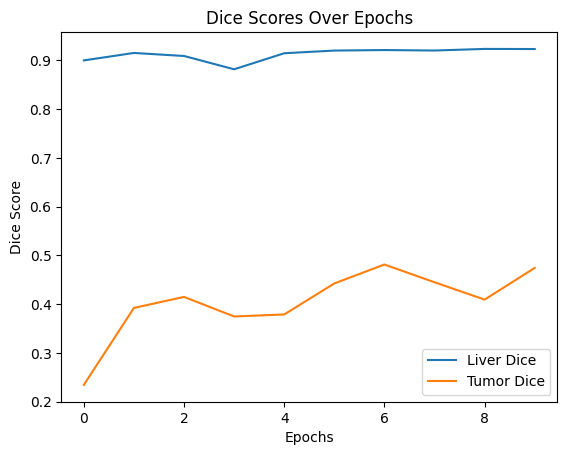

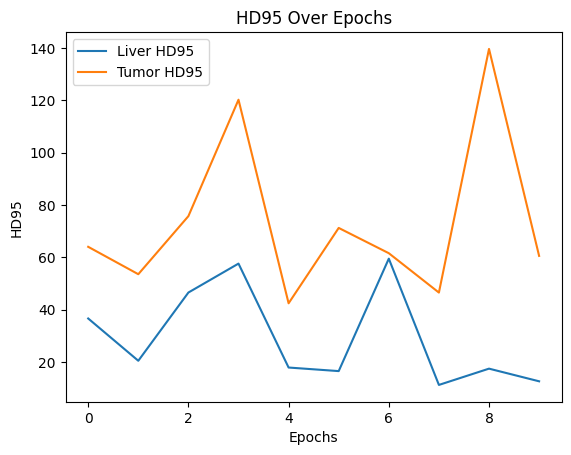

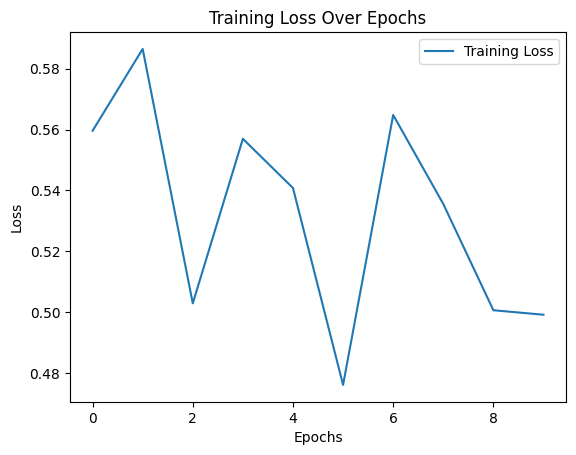

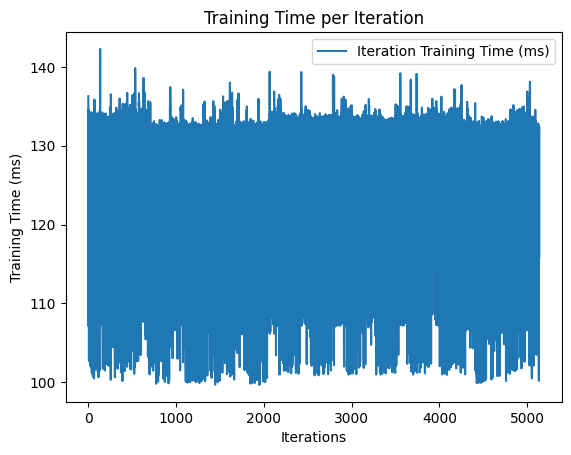

Best Liver Dice: 0.9236751794815063
Best Tumor Dice: 0.481190025806427
Best Liver HD95: 11.163393020629883
Best Tumor HD95: 42.37503433227539
Average training time per epoch: 62855.64 ms


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved metrics
save_dir = "100%"
metric_values = np.load(os.path.join(save_dir, 'metric_values.npy'))
epoch_loss_values = np.load(os.path.join(save_dir, 'epoch_loss_values.npy'))
iteration_times = np.load(os.path.join(save_dir, 'iteration_times.npy'))

# Split the metric values
liver_dice = metric_values[:, 0]
tumor_dice = metric_values[:, 1]
liver_hd95 = metric_values[:, 2]
tumor_hd95 = metric_values[:, 3]

# Plot Dice scores
plt.figure()
plt.plot(liver_dice, label='Liver Dice')
plt.plot(tumor_dice, label='Tumor Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Dice Scores Over Epochs')
plt.legend()
plt.show()

# Plot HD95 scores
plt.figure()
plt.plot(liver_hd95, label='Liver HD95')
plt.plot(tumor_hd95, label='Tumor HD95')
plt.xlabel('Epochs')
plt.ylabel('HD95')
plt.title('HD95 Over Epochs')
plt.legend()
plt.show()

# Plot epoch loss
plt.figure()
plt.plot(epoch_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot iteration times
plt.figure()
plt.plot(iteration_times, label='Iteration Training Time (ms)')
plt.xlabel('Iterations')
plt.ylabel('Training Time (ms)')
plt.title('Training Time per Iteration')
plt.legend()
plt.show()

# Print the best results
best_liver_dice = np.max(liver_dice)
best_tumor_dice = np.max(tumor_dice)
best_liver_hd95 = np.min(liver_hd95)
best_tumor_hd95 = np.min(tumor_hd95)

print(f"Best Liver Dice: {best_liver_dice}")
print(f"Best Tumor Dice: {best_tumor_dice}")
print(f"Best Liver HD95: {best_liver_hd95}")
print(f"Best Tumor HD95: {best_tumor_hd95}")

# Print the average training time per epoch based on iteration times
if iteration_times.size > 0:
    avg_iteration_time = np.mean(iteration_times)
    train_loader_len = len(iteration_times) // len(liver_dice)  # Approximate number of iterations per epoch
    avg_epoch_time = avg_iteration_time * train_loader_len
    print(f"Average training time per epoch: {avg_epoch_time:.2f} ms")
else:
    print("No iterations were recorded.")

In [17]:
cd '/mnt/largedrive0/rmojtahedi/MICCAI2024/LORA/LORA'

/mnt/largedrive0/rmojtahedi/MICCAI2024/LORA/LORA
